# Image classification in physics

### Introduction

Image classification can be applied in many different fields. Here it is used in solid state physics. In a diffraction experiment a sensor particle (for example photons or neutrons) is sent on a crystal. Depending on where the particles land after reflection, conclusions can be made about crystal structure or magnetism. A large and clean dataset is extremely important for later evaluation. 

The images we are looking at here are maps of the 2D sensor. A good image is when only one reflection is visible (s. Fig. 1). This can be well evaluated for further analysis. However, it is problematic if there are no (s. Fig. 2) or two reflections (s. Fig. 3). An incorrect evaluated would follow and the overall data quality would suffer. Therefore, a classifier needs to be programmed to detect the bad image.

<img src="example.png" width="600px">

<center>Example of the images studied here: In (1) there is only one reflection visible, in (2) none, and in (3) two.</center>

### Code

#### 1. All the necessary books are imported.

In [54]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import random

#### 2. Import and display the images.

There are 56 images in total. Of these, 32 are good and 24 are bad. This is a relatively small amount of data, but should be enough for a proof of concept.

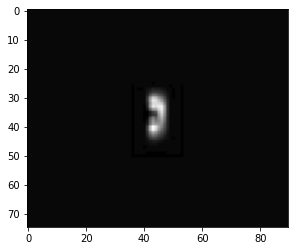

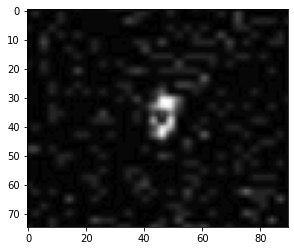

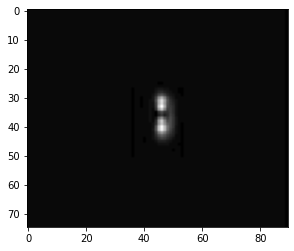

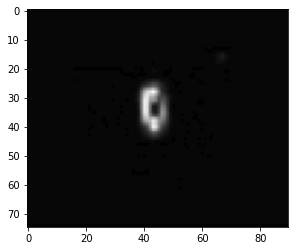

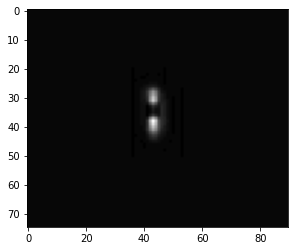

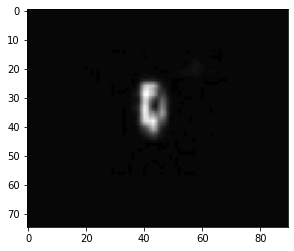

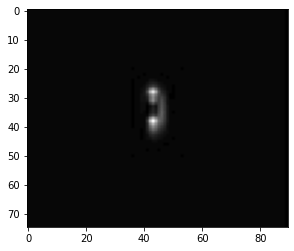

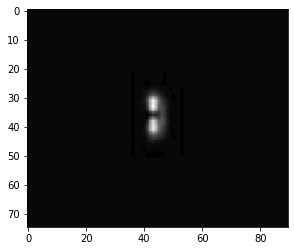

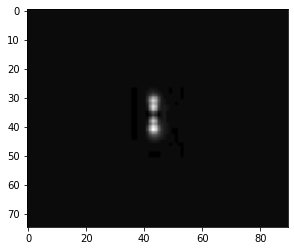

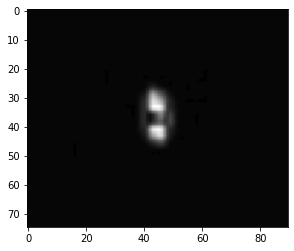

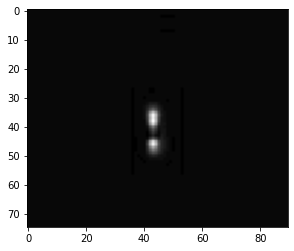

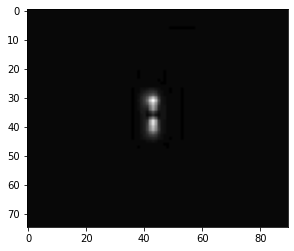

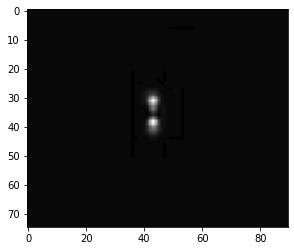

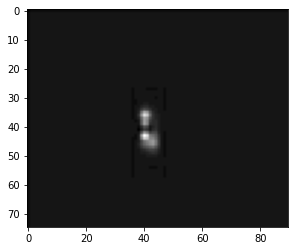

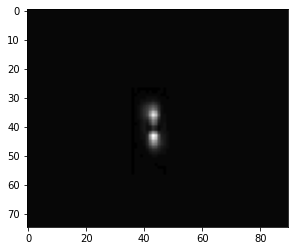

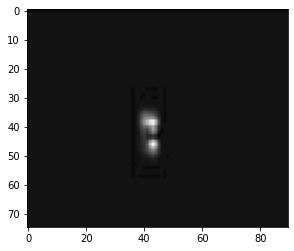

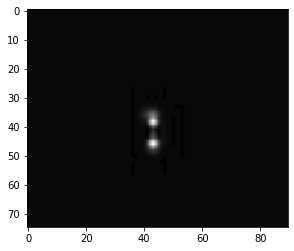

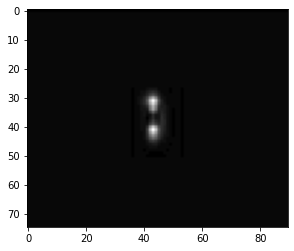

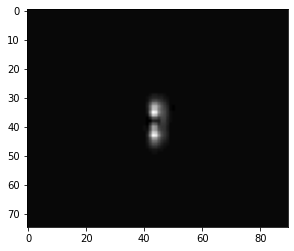

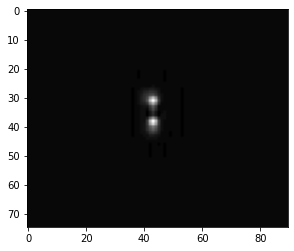

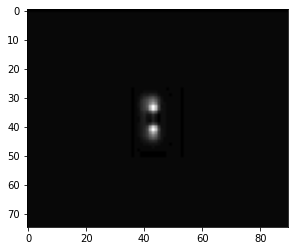

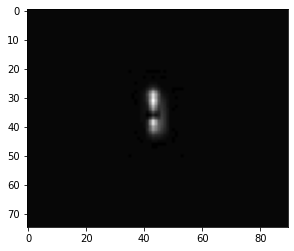

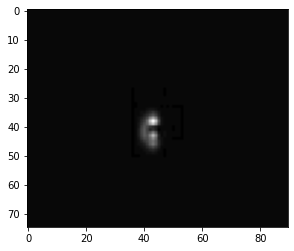

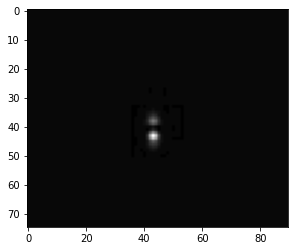

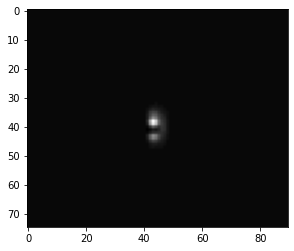

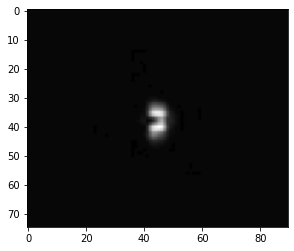

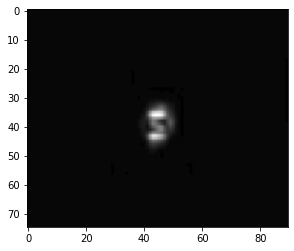

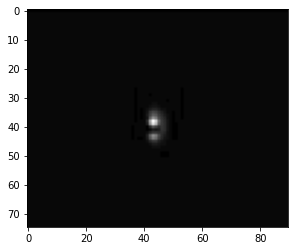

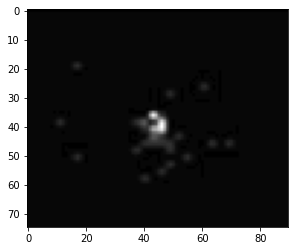

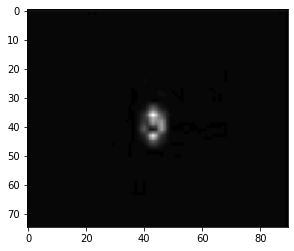

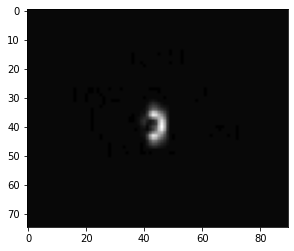

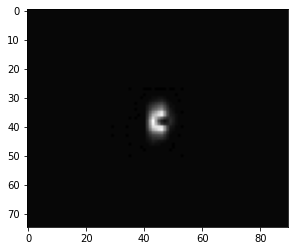

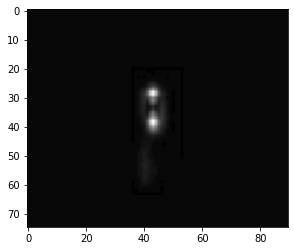

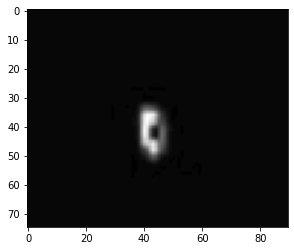

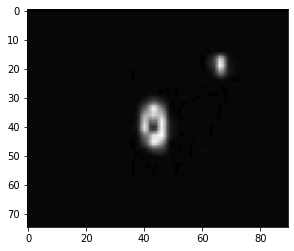

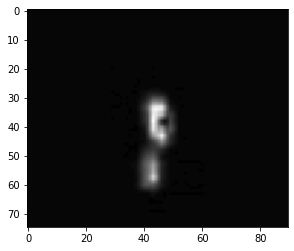

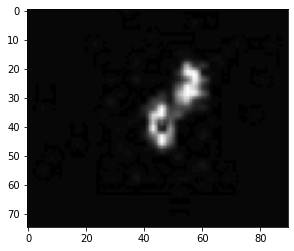

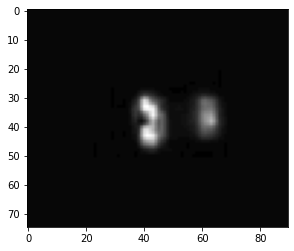

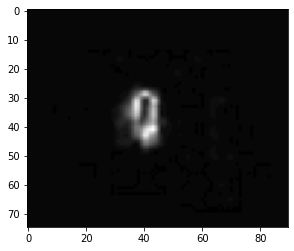

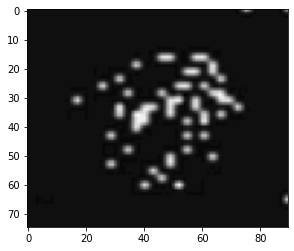

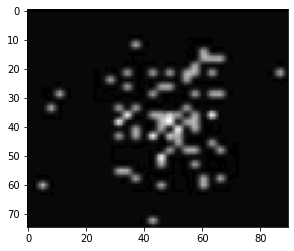

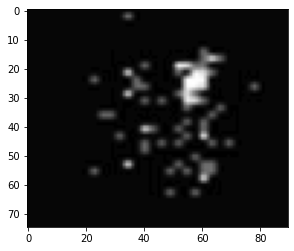

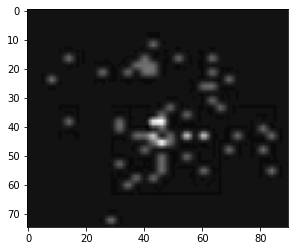

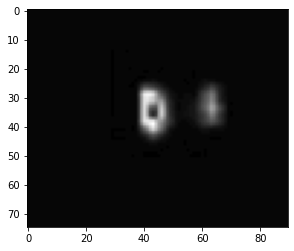

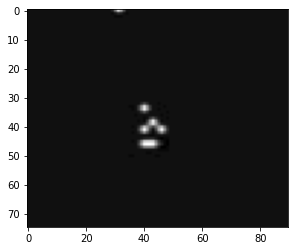

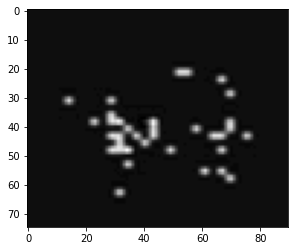

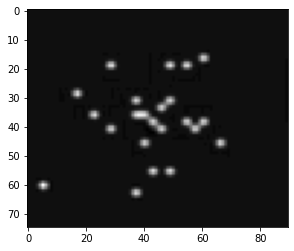

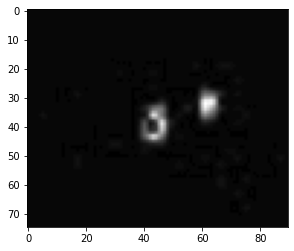

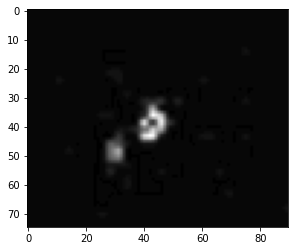

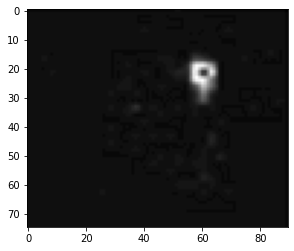

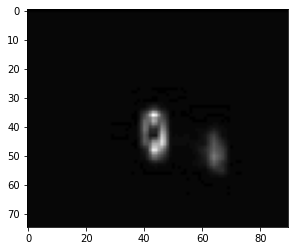

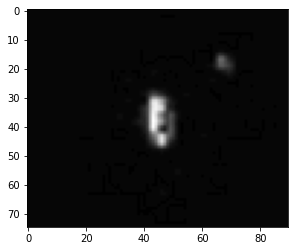

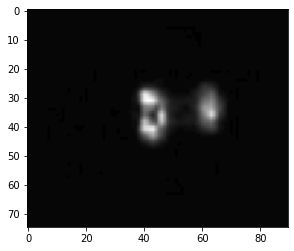

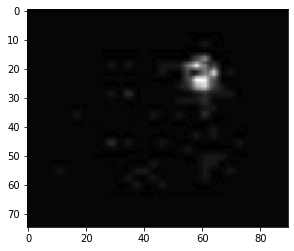

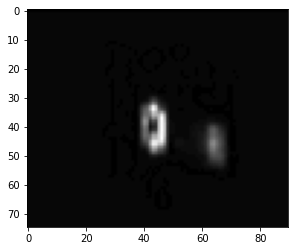

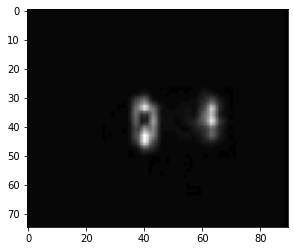

In [55]:
#Location of the pictures
DIR = "C:/Users/Janni/Documents/Projekte/ImageClassification/Pic"
#The Pictures are in the folders 'Good' and 'Bad'
Quality = ['Good','Bad']
for i in Quality:
    path = os.path.join(DIR, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #Grayscale to reduce the amount of data
        plt.imshow(img_array,cmap='gray') #Display the images also in black and white
        plt.show()

#### 3.  Putting the data in the right form

The images from the folders must be saved into an array. This has the form \[[np.Array for 1. img, 0 or 1 (for good or bad)], [[np.Array for 2. img, 0 or 1 (for good or bad)], ...].

In [56]:
#The image size is 75x75
IMG_SIZE = 75
data = []


for category in Quality:
    path = os.path.join(DIR,category)  
    class_num = Quality.index(category)  # classification: 0=good 1=bad

    for img in tqdm(os.listdir(path)):  # iterate over all images
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
        data.append([new_array, class_num])

print(len(data))

100%|████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1422.88it/s]

56


#### 4. Randomize the data and separate in X and y 

In [57]:
random.shuffle(data)

# Put picture arrays in X and label in y
X = []
y = []
for features,label in data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.asarray(y)
#Divide by 255 to normalize rgb values
X = X/255

#### 5. Creating the convolutional  neural network

The convolutional neural network has different layers that are needed for the image recognition:
1.	In the convolutional layer different filter are going over the picture and take a small part of it (in our case a 2x2 matrix). The values in the matrix are multiplied in different ways and the results are put back together. The different filters can detect either edges, vertical lines, horizontal lines or etc.
In a next step the ReLu function is used to remove all the black elements. This will make the colour change more abruptly and features can be recognized better.
2.	The pooling layer will delete unnecessary information. This will reduce the computing effort and prevent overfitting.
In our example we repeat step 1 and 2 once.
3.	The fully connected Layer will create a 1D Array with all the data for the feature extraction.
In a final step, the data is then classified using a sigmoid function.


In [58]:
#Building sequential model
model = Sequential()
#First convolutional layer to detect feauters
#256 Filters with the size 2x2
model.add(Conv2D(256, (2, 2), input_shape=X.shape[1:]))
#ReLU activation function
model.add(Activation('relu'))
#Reducing the image size by half to reduce number of parameters
model.add(MaxPooling2D(pool_size=(2, 2)))
#Dropout layer to avoid overfitting
model.add(Dropout(0.1))

#Repeat
model.add(Conv2D(256, (2, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))

#Convert 3D feature map to 1D vector
model.add(Flatten())

#Fully connected layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
#Final layer with sigmoid function
model.add(Dense(1, activation='sigmoid'))

#Compile with adam optimizer
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Fit Model with 10 epochs and a split for validation
model.fit(X, y, epochs=10, validation_split=0.2)

Epoch 1/10
2/2 [==============================] - 3s 899ms/step - loss: 0.7017 - accuracy: 0.5000 - val_loss: 0.7699 - val_accuracy: 0.5833
Epoch 2/10
2/2 [==============================] - 2s 655ms/step - loss: 0.7896 - accuracy: 0.5682 - val_loss: 0.6733 - val_accuracy: 0.4167
Epoch 3/10
2/2 [==============================] - 2s 681ms/step - loss: 0.6674 - accuracy: 0.4318 - val_loss: 0.6600 - val_accuracy: 0.5833
Epoch 4/10
2/2 [==============================] - 2s 630ms/step - loss: 0.6387 - accuracy: 0.5682 - val_loss: 0.5981 - val_accuracy: 0.8333
Epoch 5/10
2/2 [==============================] - 2s 600ms/step - loss: 0.5590 - accuracy: 0.8182 - val_loss: 0.5095 - val_accuracy: 0.9167
Epoch 6/10
2/2 [==============================] - 2s 604ms/step - loss: 0.4545 - accuracy: 0.9545 - val_loss: 0.4289 - val_accuracy: 0.8333
Epoch 7/10
2/2 [==============================] - 2s 597ms/step - loss: 0.3926 - accuracy: 0.7727 - val_loss: 0.3219 - val_accuracy: 0.9167
Epoch 8/10
2/2 [====

#### 6. Evaluate the model

The accuracy of the model after a small number of runs is already quite good. After 10 runs the accuracy is at 0.92. For further validation we can classify some sample images below and check the results. It turns out that all images have been classified correctly. In conclusion, it can be said that despite the small amount of data and relatively simple neural network, a good result has been generated. 

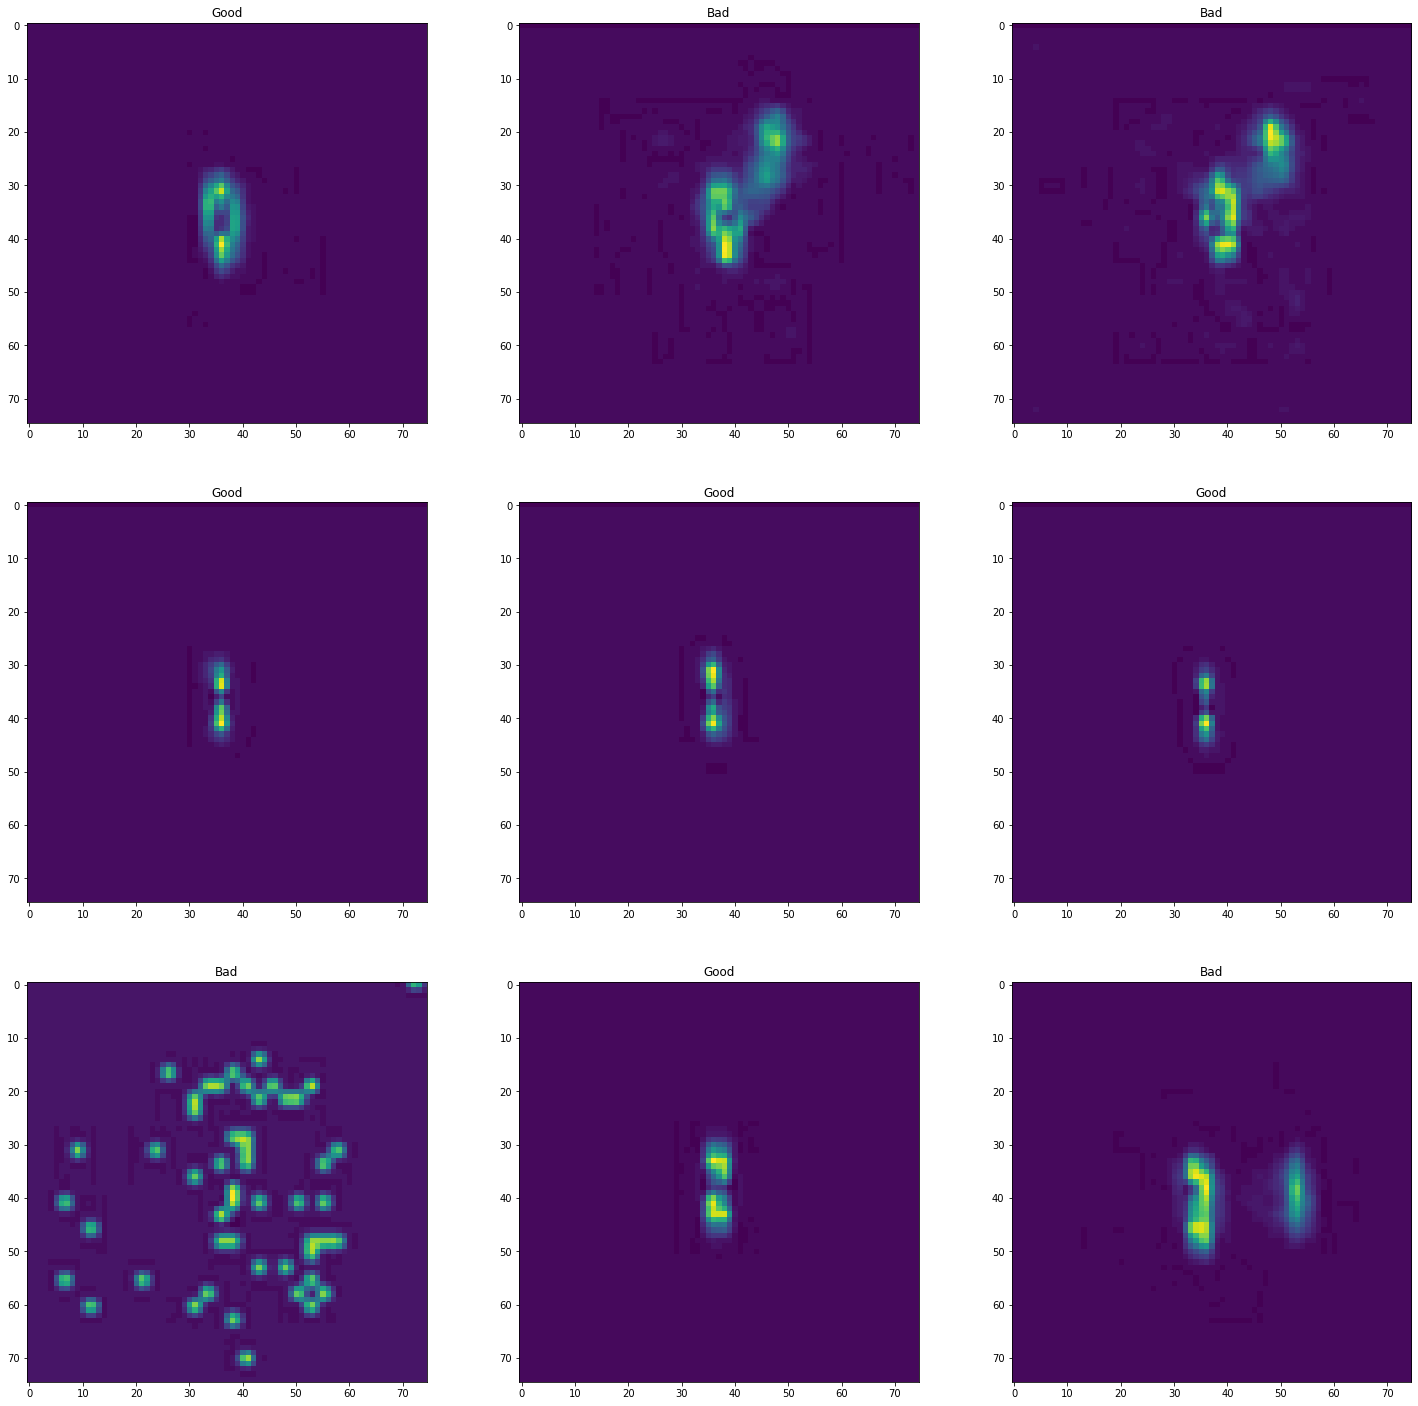

In [60]:
fig, axs = plt.subplots(3, 3,figsize=(25,25))
for i in range(1,10):
    path = "Pic_test/" + str(i) + ".png"
    test_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_array = keras.preprocessing.image.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    
    if predictions[0][0] < 0.5: lab = "Good"
    else: lab = "Bad"
        
    axs[int((i-1)/3), (i-1)%3].imshow(test_img)
    axs[int((i-1)/3), (i-1)%3].set_title(lab)
    